In [2]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d

import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

index_count = len(train.columns) if len(train.columns) > len(test.columns) else len(test.columns)

for i in range(index_count):
    splitter_1 = '\t' if len(train.columns[i]) > 7 else '\t\t'
    r_str_1 = f'{test.columns[i]}{splitter_1}{test.dtypes[i]}\t\t{test.count()[i]}' if i < len(test.columns) else ''
    print(f'{train.columns[i]}{splitter_1}{train.dtypes[i]}\t\t{train.count()[i]}\t----\t{r_str_1}')

Id		int64		10000	----	Id		int64		5000
DistrictId	int64		10000	----	DistrictId	int64		5000
Rooms		float64		10000	----	Rooms		float64		5000
Square		float64		10000	----	Square		float64		5000
LifeSquare	float64		7887	----	LifeSquare	float64		3959
KitchenSquare	float64		10000	----	KitchenSquare	float64		5000
Floor		int64		10000	----	Floor		int64		5000
HouseFloor	float64		10000	----	HouseFloor	float64		5000
HouseYear	int64		10000	----	HouseYear	int64		5000
Ecology_1	float64		10000	----	Ecology_1	float64		5000
Ecology_2	object		10000	----	Ecology_2	object		5000
Ecology_3	object		10000	----	Ecology_3	object		5000
Social_1	int64		10000	----	Social_1	int64		5000
Social_2	int64		10000	----	Social_2	int64		5000
Social_3	int64		10000	----	Social_3	int64		5000
Healthcare_1	float64		5202	----	Healthcare_1	float64		2623
Helthcare_2	int64		10000	----	Helthcare_2	int64		5000
Shops_1		int64		10000	----	Shops_1		int64		5000
Shops_2		object		10000	----	Shops_2		object		5000
Price		float64		10000	----	


In [14]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, df):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = df.median()
    
    def transform(self, df):
        """Трансформация данных"""
        #Ids
        df = df.set_index('Id')

        #DistrictId
        df.drop('DistrictId', inplace=True, axis=1)
        
        #NaN processing
        df.fillna(self.medians, inplace=True)

        #Dummy processing
        df = pd.get_dummies(df)
        df.head()

        # Rooms
        df.loc[(df['Rooms'] < 1) | (df['Rooms'] > 9), 'Rooms'] = df['Rooms'].median()

        return df

In [6]:
target_name = 'Price'

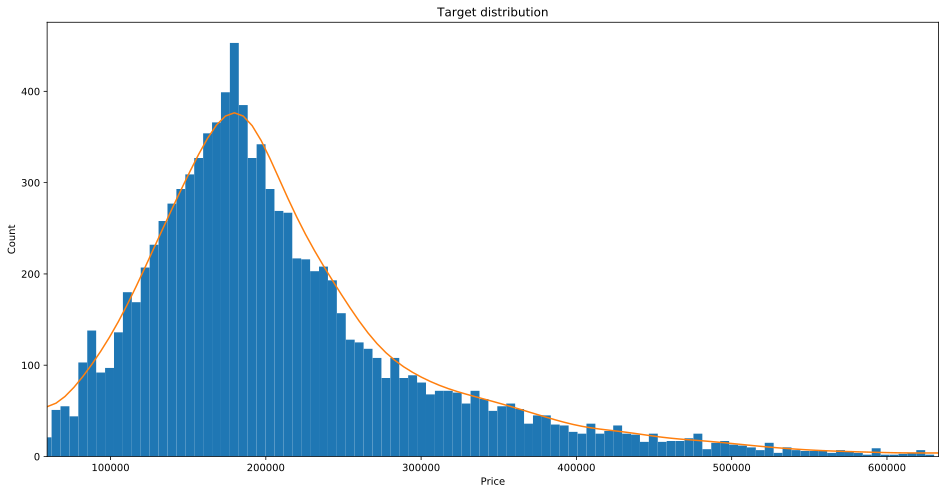

In [7]:
plt.figure(figsize = (16, 8))

n, bins, patches = plt.hist(train['Price'], bins=100, align='left')
plt.ylabel('Count')
plt.xlabel('Price')

n = np.insert(n, n.argmax(), n[n.argmax()])
nsmoothed = gaussian_filter1d(n, sigma=3)

ax = plt.subplot(111)
ax.set_xlim(bins[0], bins[-1])

plt.plot(bins, nsmoothed)

plt.title('Target distribution')
plt.show()

In [8]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обработка

1. Выкинем DistrictId
2. Заполним пропуски медианами
3. Для категориальных сделаем Dummy-переменные
6. Построим модель

In [15]:
dp = DataPreprocessing()

In [16]:
dp.fit(train)

In [17]:
target = train[target_name]
train = train.drop(target_name, axis=1)

KeyError: 'Price'

In [18]:
train = dp.transform(train)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.33, shuffle=True, random_state=21)

In [73]:
dtr = DecisionTreeRegressor(max_depth=8, min_samples_split=70, max_features=12, random_state=21)

In [74]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=12, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=70,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=21, splitter='best')

In [75]:
y_train_pred = dtr.predict(X_train)
y_valid_pred = dtr.predict(X_valid)

In [76]:
print(f"R_train: {r2_score(y_train, y_train_pred)}; R_valid: {r2_score(y_valid, y_valid_pred)}")

R_train: 0.6913338620861414; R_valid: 0.6280546276265091


In [77]:
parameters = {
    'min_samples_split': [30,50,70,100],
    'max_features': np.arange(10,14),
    'max_depth': np.arange(6, 9),
}

clf = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    return_train_score=True
)

In [70]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([6, 7, 8]),
                         'max_features': array([10, 11, 12, 13]),
                         'min_sam

In [71]:
cv_results = pd.DataFrame(clf.cv_results_)

In [72]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

,param_max_depth,param_max_features,param_min_samples_split,mean_test_score,mean_train_score
42,8,12,70,0.618331,0.701944
31,7,13,100,0.616080,0.669881
35,8,10,100,0.615304,0.679953
21,7,11,50,0.609710,0.676437
25,7,12,50,0.609075,0.686549
45,8,13,50,0.608779,0.707297
36,8,11,30,0.608471,0.710704
44,8,13,30,0.606481,0.714382
47,8,13,100,0.602748,0.679091
28,7,13,30,0.600996,0.683333


In [79]:
train_medians = train.median()

In [82]:
test = test.fillna(train_medians)

In [87]:
test.loc[(test['Rooms'] < 1) | (test['Rooms'] > 9), 'Rooms'] = train_medians['Rooms']

In [89]:
test = pd.get_dummies(test)

In [92]:
test = test.set_index('Id')
test.drop('DistrictId', inplace=True, axis=1)

In [93]:
y_predict = dtr.predict(test)

In [98]:
y_predict

array([153733.66380144, 118831.33497815, 156360.81862494, ...,
       153733.66380144, 192601.69167059, 244792.95753645])

In [97]:
y_predict.to_csv("test.csv", sep=";", index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'